### Clasificación de imágenes multiespectro con CNN

In [388]:
import numpy as np
import random
import spectral
import scipy
import scipy.ndimage
from scipy.ndimage import rotate
import scipy.io as sio
import matplotlib.pyplot as plt


from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from tensorflow.keras import utils as np_utils
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD
from keras import backend as K

K.set_image_data_format('channels_last') # Coloca los canales/bandas en el último lugar del tensor (batch, altura, anchura, canales)
import warnings
warnings.filterwarnings('ignore')

In [389]:
# Cargar la imagen y las etiquetas
data = sio.loadmat('Data\\salinas_corrected.mat')['salinas_corrected']
labels = sio.loadmat('Data\\salinas_gt.mat')['salinas_gt']

# Mostrar cuantas veces aparece cada etiqueta
uniqueLabels, labelCounts = np.unique(labels, return_counts=True)
for l, c in zip(uniqueLabels, labelCounts):
    print(f'{l} --> {c}')

0 --> 56975
1 --> 2009
2 --> 3726
3 --> 1976
4 --> 1394
5 --> 2678
6 --> 3959
7 --> 3579
8 --> 11271
9 --> 6203
10 --> 3278
11 --> 1068
12 --> 1927
13 --> 916
14 --> 1070
15 --> 7268
16 --> 1807


In [390]:
# Aplicar PCA
new_data = np.reshape(data, (-1, data.shape[2])) # Reshapea de 3D (ancho, alto, bandas) a 2D (pixels, bandas): (512, 217, 204) --> (111104, 204)
pca = PCA(n_components=30, whiten=True) # Selecciona los componentes principales y los normaliza
new_data = pca.fit_transform(new_data)
new_data = np.reshape(new_data, (data.shape[0], data.shape[1], 30))

In [391]:
# Crea un borde de ceros, se usa en la siguiente celda para crear parches
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [392]:
# Crear parches (regiones cuadradas alrededor de cada pixel)
windowSize = 1
margin = int((windowSize - 1) / 2) # Pixeles a incluir alrededor de cada pixel parcheado
zeroPaddedX = padWithZeros(new_data, margin=margin) # Crea un borde de ceros alrededor de la imagen para que todos los pixeles tengan parches completos
patchesData = np.zeros((new_data.shape[0] * new_data.shape[1], windowSize, windowSize, new_data.shape[2])) # Array para almacenar datos de los parches (alto*ancho, 1, 1, 204 [bandas])
patchesLabels = np.zeros((new_data.shape[0] * new_data.shape[1])) # Array para almacenar la etiqueta de cada parche
patchIndex = 0 # Inicia un índice para cada parche
removeZeroLabels = True # Bandera para eliminar los parches con etiqueta 0

# Obtener el parche de cada pixel
for r in range(margin, zeroPaddedX.shape[0] - margin): # Índice de la fila, recorre toda la imagen evitando el padding (de margin=0 a altura-margin=altura completa)
    for c in range(margin, zeroPaddedX.shape[1] - margin): # Índice de la columna, haciendo que cada pixel tenga las coordenadas (r, c)
        patch = zeroPaddedX[r - margin:r + margin + 1, c-margin:c + margin + 1] # Selecciona los pixels de alrededor del pixel (parche)
        patchesData[patchIndex, :, :, :] = patch # Guarda los datos del parche
        patchesLabels[patchIndex] = labels[r-margin, c-margin] # Guarda la etiqueta de ese parche siguiendo el mismo índice
        patchIndex += 1

# Eliminar los parches etiquetados como 0 (no tienen info o son áreas de fondo no útiles para el entrenamiento)
if removeZeroLabels:
    patchesData = patchesData[patchesLabels > 0, :, :, :]
    patchesLabels = patchesLabels[patchesLabels > 0]
    patchesLabels -= 1

In [393]:
print(f'Forma del array de parches:')
print(f'Parches: {patchesData.shape[0]}\t Altura: {patchesData.shape[1]}\t Anchura: {patchesData.shape[2]}\t Bandas espectrales: {patchesData.shape[3]}')

Forma del array de parches:
Parches: 54129	 Altura: 1	 Anchura: 1	 Bandas espectrales: 30


In [394]:
# Crear los conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(patchesData, patchesLabels, train_size=0.75, stratify=patchesLabels, random_state=11)

In [395]:
# Sobremuestreo de las clases minoritarias para equilibrar las apariciones
uniqueLabels, labelCounts = np.unique(y_train, return_counts=True)
maxCount = np.max(labelCounts) # Apariciones de la clase mayoritaria
labelInverseRatios = maxCount / labelCounts # Array que invierte el peso de las apariciones de cada clase
newX = X_train[y_train == uniqueLabels[0], :].repeat(round(labelInverseRatios[0]), axis=0) # Multiplica las muestras de la primera clase por el ratio invertido
newY = y_train[y_train == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0) # Misma operación para mantener la relación entre X e y

# Recorrer las demás clases aplicando las dos operaciones anteriores (apariciones * ratio inverso)
for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
    cX = X_train[y_train == label, :].repeat(round(labelInverseRatio), axis=0)
    cY = y_train[y_train == label].repeat(round(labelInverseRatio), axis=0)

    # Ir añadiendo las clases ya equilibradas
    newX = np.concatenate((newX, cX))
    newY = np.concatenate((newY, cY))

# Permutar los datos para que las clases no aparezcan seguidas (ej: [1, 1, 1, 1, 2, 2, 2, 2...] --> [1, 2, 2, 4, 6, 1, 3, 4...])
np.random.seed(seed=42)
random_permutation = np.random.permutation(newY.shape[0]) # Genera una lista aleatoria de índices
newX = newX[random_permutation, :] # Reorganiza el array con el nuevo orden aleatorio de índices
newY = newY[random_permutation] # Lo mismo

print(f'Forma antes del sobremuestreo: {X_train.shape}')
print(f'Forma despues del sobremuestreo: {newX.shape}')

# Asignar los nuevos conjuntos con sobremuestreo
X_train, y_train = newX, newY

Forma antes del sobremuestreo: (40596, 1, 1, 30)
Forma despues del sobremuestreo: (138400, 1, 1, 30)


In [396]:
# Hacer data augmentation a la mitad de los parches
for i in range(int(X_train.shape[0]/2)):
    patch = X_train[i, :, :, :] # Selecciona el parche con todos sus datos (alto, ancho, bandas)
    num = random.randint(0, 2) # Genera un número aleatorio (0, 1 o 2)
    if num == 0: # Volteo vertical
        flipped_patch = np.flipud(patch)
    elif num == 1:  # Volteo horizontal (izq a dcha)
        flipped_patch = np.fliplr(patch)
    else: # Rotación aleatoria
        no = random.randrange(-180,180,30)
        flipped_patch = scipy.ndimage.rotate(patch, no,axes=(1, 0),reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
    
    # Asignar el nuevo parche augmentado
    patch2 = flipped_patch
    X_train[i, :, :, :] = patch2

In [397]:
# Ajustar a las dimensiones que puede manejar el modelo
print(f'Forma inicial X train --> Muestras: {X_train.shape[0]}\tParche: {X_train.shape[1]}x{X_train.shape[2]}\tBandas: {X_train.shape[3]}')

X_train = X_train.reshape(X_train.shape[0], X_train.shape[3]) # Elimina la dimensión 1x1 y recoloca las 30 bandas espectrales
print(f'Primera reorganización --> Muestras: {X_train.shape[0]}\tBandas: {X_train.shape[1]}')

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # Reajustar la forma a 3D añadiendo una tercera dimensión necesaria para una CNN
print(f'Forma final X train --> Muestras: {X_train.shape[0]}\tBandas: {X_train.shape[1]}\tCanal extra: {X_train.shape[2]}')

print()
print(f'Forma inicial y train --> Muestras: {y_train.shape[0]}')
y_train = np_utils.to_categorical(y_train) # Aplica one-hot a las etiquetas
print(f'Forma final y train --> Muestras: {y_train.shape[0]}\tColumnas One-Hot: {y_train.shape[1]}')



Forma inicial X train --> Muestras: 138400	Parche: 1x1	Bandas: 30
Primera reorganización --> Muestras: 138400	Bandas: 30
Forma final X train --> Muestras: 138400	Bandas: 30	Canal extra: 1

Forma inicial y train --> Muestras: 138400
Forma final y train --> Muestras: 138400	Columnas One-Hot: 16


In [398]:
# Construcción del modelo
model = Sequential()

# Capa convolucional, recibe de input las bandas espectrales y el canal extra
model.add(Input(shape=(30, 1)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D())
model.add(Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

# Capas densas
model.add(Dense(units=128, activation='relu')) 
model.add(Dense(units=64, activation='relu'))

# Capa de salida, una neurona por clase posible
model.add(Dense(16, activation='softmax'))

# Crear el optimizador
sgd = SGD(learning_rate=0.0001,
          momentum=0.9, # Acelera el descenso del gradiente (combina gradiente actual y una fracción [0.9] del anterior)
          nesterov=True # Momentum de Nesterov: Calcula un paso adelantado para precisar mejor la dirección del gradiente
          )
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 30, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 15, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 7, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │        14,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,440 (99.38 KB)

 Trainable params: 25,440 (99.38 KB)

 Non-trainable params: 0 (0.00 B)

In [399]:
# Entrenamiento
model.fit(X_train, y_train,
          batch_size=64,
          epochs=15,
          verbose=True)

Epoch 1/15
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.0761 - loss: 2.7523
Epoch 2/15
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.2035 - loss: 2.5383
Epoch 3/15
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6371 - loss: 1.7077
Epoch 4/15
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8170 - loss: 0.7960
Epoch 5/15
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8845 - loss: 0.4606
Epoch 6/15
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9146 - loss: 0.3205
Epoch 7/15
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9275 - loss: 0.2551
Epoch 8/15
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9362 - loss: 0.2178
Epoch 9/15
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9423 - loss: 0.1912
Epoch 10/15
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9440 - loss: 0.1773
Epoch 11/15
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9479 - loss: 0.1627
Epoch 12/15
2163/2163 ━━━━━━━━

In [400]:
# Medidas del terreno
alto = labels.shape[0]
ancho = labels.shape[1]
print(f'Pixels altura: {alto}\tPixels anchura: {ancho}')

Pixels altura: 512	Pixels anchura: 217


In [401]:
patches = []
positions = []
PATCH_SIZE = 1 # Tamaño de los parches (1 píxel)
outputs = np.zeros((alto, ancho)) # Array de 0s con dimensión alto x ancho

# Seleciona un parche según las coordenadas de altura y anchura
def Patch(data, alto_idx, ancho_idx):
    alto_slice = slice(alto_idx, alto_idx+PATCH_SIZE)
    ancho_slice = slice(ancho_idx, ancho_idx+PATCH_SIZE)
    parche = data[alto_slice, ancho_slice, :]
    return parche

In [402]:
# Obtener los parches de la imagen al completo
for i in range(alto):
    for j in range(ancho):
        target = int(labels[int(i + PATCH_SIZE/2), int(j + PATCH_SIZE/2)]) # Apunta a la etiqueta correspondiente del centro del parche
        if target == 0: # Obvia la etiqueta si es 0 (se eliminaron, área sin info o poco útil)
            continue
        else:
            img_patch = Patch(new_data, i, j) # Selecciona el parche de ese píxel (en este caso es el propio pixel)
            patches.append(img_patch.reshape(1, img_patch.shape[2], img_patch.shape[0]).astype('float32')) # Almacena el parche con tipo float y forma (1, 1, 30)
            positions.append((int(i + PATCH_SIZE/2), int(j + PATCH_SIZE/2))) # Almacena la posición central del parche (al ser un solo pixel, pues mismas coordenadas)

# Crear un array con la lista de parches
patches = np.concatenate(patches, axis=0)
print(f'Parches: {patches.shape[0]}\t\tBandas: {patches.shape[1]}\tPixels (alto * ancho): {patches.shape[2]}')

Parches: 54129		Bandas: 30	Pixels (alto * ancho): 1


In [403]:
# Realizar las predicciones para el total de parches
predictions = model.predict(patches)

# Almacenar la predicción para cada píxel segun las coordenadas
for pred, pos in zip(predictions, positions):
    outputs[pos[0]][pos[1]] = np.argmax(pred)

1692/1692 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step


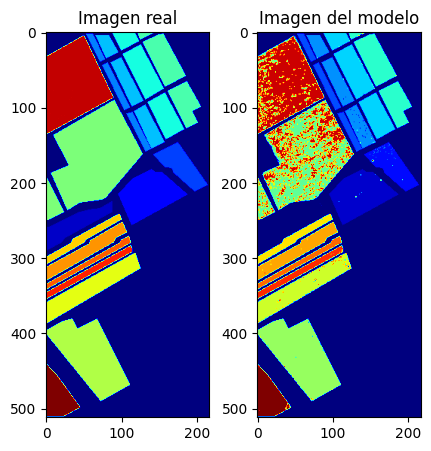

In [404]:
# Mostrar la imagen real y la predicción del modelo
fig, axes = plt.subplots(1, 2, figsize=(5,5))

axes[0].imshow(labels, cmap='jet')
axes[0].set_title('Imagen real')

axes[1].imshow(outputs.astype(int), cmap='jet')
axes[1].set_title('Imagen del modelo')

plt.show()